In [1]:
# QCA 1D <Quantum Cellular Automata in 1-dimention>
# Quantum Version of Wolfram's ECA <Elementary Cellular Automata>

#---import
# qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import *

# math & graph
import numpy as np
import matplotlib.pyplot as plt
from   matplotlib.animation import FuncAnimation
from   matplotlib import font_manager
from PIL import Image
from IPython.display import Image as IPImage
import IPython.display as display

# sim(MPS)
from qiskit import  transpile
from qiskit_aer import AerSimulator

In [2]:
# Define cccnot
def cccnot(circuit, c1, c2, c3, target):
    circuit.ccx(c1, c2, 0)
    circuit.ccx(c3, 0, target)
    circuit.ccx(c1, c2, 0)

# Function to generate rules from rule number
def generate_rule(rule_number):
    rule_bin = np.binary_repr(rule_number, width=8)
    rule = []
    for i, bit in enumerate(rule_bin[::-1]):
        if bit == '1':
            rule.append([bool(i & 4), bool(i & 2), bool(i & 1)])
    return rule

def add_rule(circuit, n, timestep, position, rules):
    for rule in rules:
        if position == 0:  # Cell is on the left edge
            if rule[0]:
                continue
            for i in range(1, 3):
                if not rule[i]:
                    circuit.x(n * timestep + position + i)
            circuit.ccx(
                n * timestep + position + 1,
                n * timestep + position + 2,
                n * (timestep + 1) + position + 1
            )
            for i in range(1, 3):
                if not rule[i]:
                    circuit.x(n * timestep + position + i)
        elif position == n - 1:  # Cell is on the right edge
            if rule[2]:
                continue
            for i in range(2):
                if not rule[i]:
                    circuit.x(n * timestep + position + i)
            circuit.ccx(
                n * timestep + position,
                n * timestep + position + 1,
                n * (timestep + 1) + position + 1
            )
            for i in range(2):
                if not rule[i]:
                    circuit.x(n * timestep + position + i)
        else:  # Cells in the middle
            for i in range(3):
                if not rule[i]:
                    circuit.x(n * timestep + position + i)
            cccnot(
                circuit,
                n * timestep + position,
                n * timestep + position + 1,
                n * timestep + position + 2,
                n * (timestep + 1) + position + 1
            )
            for i in range(3):
                if not rule[i]:
                    circuit.x(n * timestep + position + i)

def add_rules(circuit, n, m, rule_number):
    rules = generate_rule(rule_number)
    for i in range(m - 1):
        for j in range(n):
            add_rule(circuit, n, i, j, rules)
    for i in range(0, n * m):
        circuit.measure(i + 1, i)

In [3]:
# Parameter settings block
n = 7  # Length of the 1D cellular automaton cells
m = 8  # Number of timesteps

cirq1 = QuantumCircuit(n * m + 1, n * m)

# Specify the rule number
rule_number = 122

# Set initial state
cirq1.x(4)

# Enable superposition
for i in range(n):
    if i != 3:
        cirq1.h(i + 1)

# Add rules
add_rules(cirq1, n, m, rule_number)

# Execute the job
shots = 1024
simulator = AerSimulator(method='matrix_product_state')
tcirc = transpile(cirq1, simulator)
result = simulator.run(tcirc).result()
counts = result.get_counts(cirq1)
#print("Time taken: {} sec".format(result.time_taken))
#print(counts)

# Transfer the measurement results to a frequency matrix
grid = np.zeros((m, n))
for bitstring, cnt in counts.items():
    prob = cnt / shots
    for idx, c in enumerate(reversed(bitstring)):
        if c == '1':
            grid[idx // n, idx % n] += prob

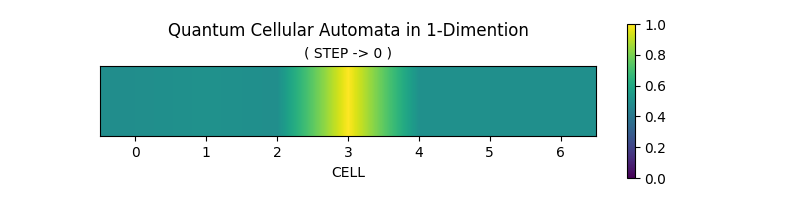

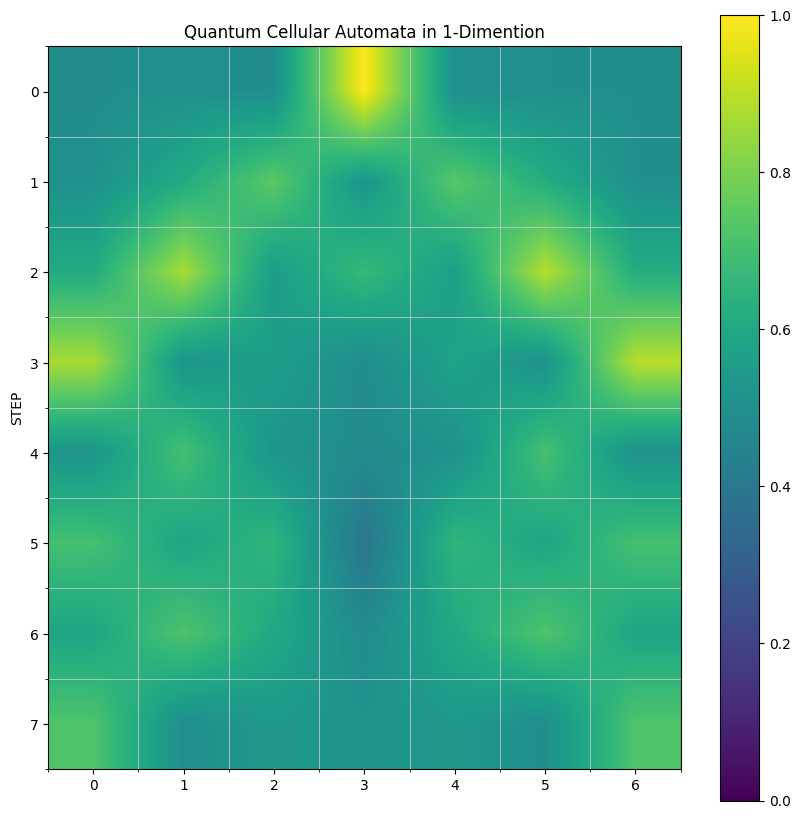

In [4]:
#--- Draw EveryThing
# Font settings for linux(OpenSuse Tumbleweed)
font_path = "/usr/share/fonts/truetype/NotoSans-Regular.ttf"
font_prop = font_manager.FontProperties(fname=font_path)

# Create and save the animatio
fig_anim, ax_anim = plt.subplots(figsize=(8, 2))
im = ax_anim.imshow(grid[0:1], interpolation='bilinear', vmin=0, vmax=1)
cbar = fig_anim.colorbar(im, ax=ax_anim, orientation='vertical')

def update(frame):
    ax_anim.clear()
    ax_anim.set_title('Quantum Cellular Automata in 1-Dimention\n', loc='center')
    ax_anim.text(0.5, 1.12, f'( STEP -> {frame} )', ha='center', transform=ax_anim.transAxes)
    ax_anim.imshow(grid[frame:frame+1], interpolation='bilinear', vmin=0, vmax=1)
    #ax_anim.set_ylabel('STEP')
    ax_anim.set_xlabel('CELL')
    ax_anim.set_yticks([])
    ax_anim.set_ylim([0.5, -0.5]) 

ani = FuncAnimation(fig_anim, update, frames=m, repeat=False)

# Save each frame as a PNG image
images = []
for frame in range(m):
    update(frame)
    fig_anim.canvas.draw()
    image = np.frombuffer(fig_anim.canvas.buffer_rgba(), dtype='uint8')
    image = image.reshape(fig_anim.canvas.get_width_height()[::-1] + (4,))
    image = image[:, :, :3]  # Remove the alpha channel
    images.append(Image.fromarray(image))

images[0].save("./images/qca1dim/qca_1d_animation.png", save_all=True, append_images=images[1:], duration=500, loop=0)
plt.close()


# Display animation
output_file_final_image="./images/qca1dim/qca_1d_animation.png"
with open(output_file_final_image, 'rb') as f:
    display.display(display.Image(data=f.read(), format='png'))

# Save big picture
fig, ax = plt.subplots(figsize=(10.2, 10.2))
im = ax.imshow(grid[:m], interpolation='bilinear', vmin=0, vmax=1)
ax.set_ylabel('STEP')
ax.set_title('Quantum Cellular Automata in 1-Dimention')
ax.set_xticks(np.arange(-0.5, grid.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, grid.shape[0], 1), minor=True)
ax.grid(which='minor', color='lightgray', linestyle='-', linewidth=0.5)
fig.colorbar(im, ax=ax, orientation='vertical')

fig.savefig("./images/qca1dim/qca_1d.png", bbox_inches='tight', format='png')
plt.close()

# Display big picture
output_file_final_image="./images/qca1dim/qca_1d.png"
with open(output_file_final_image, 'rb') as f:
    display.display(display.Image(data=f.read(), format='png'))